# Example CLOC Simulation

In [13]:
#if previously used Brian objects are preventing simulation
%reset -f
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from brian2 import *
from clocsim.base import *

import matplotlib.pyplot as plt

## Set up network

In [15]:
population = NeuronGroup(100, '''
            dv/dt = (-v - 70*mV + Rm*I) / tau : volt
            tau: second
            Rm: ohm
            I: amp''',
        threshold='v>-50*mV',
        reset='v=-70*mV'
)
population.tau = 10*ms
population.Rm = 100*Mohm
population.I = 0*mA
population.v = -70*mV

input_group = PoissonGroup(100, np.arange(100)*Hz + 10*Hz)

S = Synapses(input_group, population, on_pre='v+=5*mV')
S.connect(condition='abs(i-j)<=3')

pop_mon = SpikeMonitor(population)
state_mon = StateMonitor(population, 'v', range(10))

print("Recorded population's equations:")
population.user_equations

Recorded population's equations:


dv/dt = (I*Rm - 70.0*mV - v)/tau : volt
tau : second
Rm : ohm
I : amp


## Run simulation

In [16]:
net = Network(collect())
net.run(200*ms)

We shouldn't see the activity in the recorded group affect the controlled group, since
the control loop isn't set up yet. 

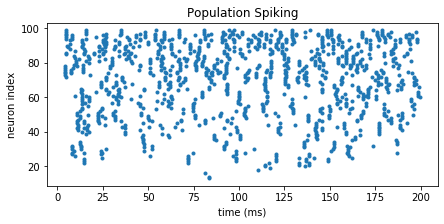

In [17]:
fig_size=(7, 3)
plt.figure(figsize=fig_size);
plt.plot(pop_mon.t / ms, pop_mon.i, '.'); 
plt.title('Population Spiking'); plt.ylabel('neuron index'); plt.xlabel('time (ms)');
plt.show();
# plt.figure(figsize=(14, 6));
# plt.plot(con_mon.t / ms, con_mon.i, '.');
# plt.title('Controlled group'); plt.ylabel('neuron index'); plt.xlabel('time (ms)');

## Control loop setup
Now we'll set up the control loop and should see activity in the controlled neurons (indices 1-10).
We'll use a simplistic setup where the recorder simply reports the voltage of a given neuron (of index 50 in our case), the controller outputs a pulse whenever
that voltage is below a certain threshold,
and the stimulator delivers a current pulse whenever the control signal is non-zero. So if everything is
wired correctly, we'll see bursts of activity in the first 10 neurons.

In [18]:
from clocsim.recorders import RateRecorder, VoltageRecorder
from clocsim.stimulators import CurrentPulseStimulator
from clocsim.base import *  # for reloading

sim = CLOCSimulator(net)
# rate_rec = RateRecorder('rec', index=range(10, 100))
# sim.inject_recorder(rate_rec, population)
v_rec = VoltageRecorder('rec', index=50)
sim.inject_recorder(v_rec, population)
sim.inject_stimulator(CurrentPulseStimulator('stim', index=range(10)), population)

We need to implement the ControlLoop object. For a more sophisticated case we'd use LoopComponent objects to decompose 
the computation in the `put_state` function.

In [19]:
trigger_threshold = -60*mV

class ReactivePulseControlLoop(ControlLoop):
    def __init__(self, pulse_current=1*mA):
        self.pulse_current = pulse_current
        self.out = {}

    def put_state(self, state_dict, time):
        v = state_dict['rec']
        if v is not None and v < trigger_threshold:
            self.out['stim'] = self.pulse_current
        else:
            self.out['stim'] = 0

    def get_ctrl_signal(self, time):
        return self.out 

sim.set_control_loop(ReactivePulseControlLoop(1*nA), poll_ctrl_period=1*ms)

And run the simulation:

In [20]:
sim.run(200*ms)

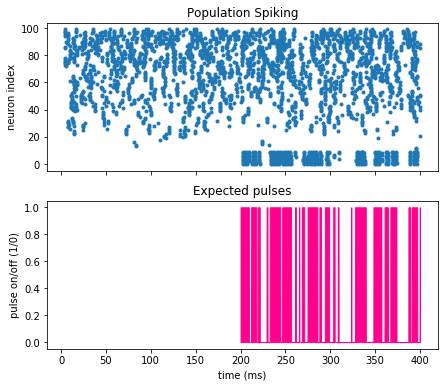

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 6));
ax1.plot(pop_mon.t / ms, pop_mon.i, '.'); 
ax1.set_title('Population Spiking'); ax1.set_ylabel('neuron index'); plt.xlabel('time (ms)');
ax2.fill_between(v_rec.mon.t / ms, (v_rec.mon.v.T < trigger_threshold)[:, 0], color='xkcd:hot pink');
plt.title('Expected pulses'); plt.xlabel('time (ms)'); plt.ylabel('pulse on/off (1/0)');


Yes, we see the control loop triggering pulses as expected.
And here's a plot of neuron 50's voltage to confirm that those pulses
are indeed where we expect them to be, whenever the voltage is
below -60 mV.

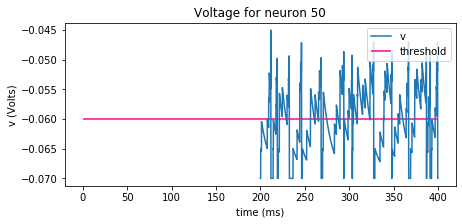

In [22]:
plt.figure(figsize=fig_size);
plt.title('Voltage for neuron 50'); plt.ylabel('v (Volts)'); plt.xlabel('time (ms)');
plt.plot(v_rec.mon.t/ms, v_rec.mon.v.T);
plt.hlines(-0.06, 0, 400, color='xkcd:hot pink');
legend(['v', 'threshold'], loc='upper right');